# [Project]  기계 시설물 센서 데이터 기반 고장 예지 프로젝트

---

## 프로젝트 목적
  - 도시철도 역사 3개소 용량(kW)별 12종 전동기 41대의 센서데이터를 활용하여 고장의 주요 유형을 예측합니다.
  - 파이선 머신러닝 라이브러리인 scikit-learn을 활용하여 센서의 수집 신호를 학습하여 고장의 유형 (베어링 불량. 회전체 불평형, 축정렬 불량, 벨트 느슨함)을 예측하는 모델을 개발합니다. 
  

---

## 활용 데이터
 - 기계 시설물 상태 모니터링 및 고장 예지를 위한 IT 센서 데이터
 - https://aihub.or.kr/aidata/30748

---

##  개요

- 이번 lab에서는 폴더에 저장된 모든 csv format의 파일을 parsing 하여 pandas dataframe으로 변환합니다.
- 이후 Machine learning에 활용하기 용이하도록 h5 형식으로 변환하여 저장합니다.
- 데이터는 /mnt/data/project2_data/ 에 저장되어 있으며, 폴더별로 장비의 특성이 분류되어 있고 파일 포맷은 csv입니다.

---

## 1. 데이터 읽기

- /mmt/data/project2_data에 들어 있는 파일을 확인해 봅니다.
- jupyter notebook에는 "%"로 시작하는 다양한 magic command가 있습니다.
- 그 중 하나는 %ls 로써 원하는 위치의 폴더 구조를 파악할 수 있습니다.
- 아래 cell을 실행하여 /mnt/data/project2_data 폴더가 어떠한 식으로 구성되어 있는지 확인할 수 있습니다.


In [1]:
%ls /mnt/data/project2_data/ -R

/mnt/data/project2_data/:
2.2kW/  55kW/

/mnt/data/project2_data/2.2kW:
L-DSF-01/  L-EF-04/  L-SF-04/  R-EF-05/

/mnt/data/project2_data/2.2kW/L-DSF-01:
정상/  축정렬불량/

/mnt/data/project2_data/2.2kW/L-DSF-01/정상:
STFCB-20201012-0105-0137_20201103_131206_002.csv
STFCB-20201012-0105-0137_20201106_131205_002.csv
STFCB-20201012-0105-0137_20201107_014205_002.csv
STFCB-20201012-0105-0137_20201107_014206_002.csv
STFCB-20201012-0105-0137_20201107_031205_002.csv
STFCB-20201012-0105-0137_20201107_084205_002.csv
STFCB-20201012-0105-0137_20201107_151205_002.csv
STFCB-20201012-0105-0137_20201107_211206_002.csv
STFCB-20201012-0105-0137_20201108_022106_002.csv
STFCB-20201012-0105-0137_20201108_022107_002.csv
STFCB-20201012-0105-0137_20201108_072107_002.csv
STFCB-20201012-0105-0137_20201108_081207_002.csv
STFCB-20201012-0105-0137_20201108_084205_002.csv
STFCB-20201012-0105-0137_20201108_084206_002.csv
STFCB-20201012-0105-0137_20201108_201205_002.csv
STFCB-20201012-0105-0137_20201109_001205_002.csv
STFCB-2

- Pathlib은 폴더/파일에 대한 다양한 연산을 제공하는 라이브러리입니다.
- 원하는 위치의 특정한 조건에 있는 파일을 가져올 수도 있고, 원하는 경로를 쉽게 만들 수도 있습니다.
- /mnt/data/project2_data/ 폴더 아래에 있는 확장자가 csv인 파일의 목록을 모두 가져오는 기능을 구현해 봅시다.

In [2]:
from pathlib import Path
import random

p = Path("/mnt/data/project2_data")
filelist = list(p.glob('**/*.csv'))

# 리스트 항목을 섞기
random.Random(1).shuffle(filelist)

# 전체 파일 개수, 배열의 처음 3개 파일이름과 마지막 3개 파일이름 출력
print('파일개수 = ', len(filelist), '개\n\n', filelist[0:3], '\n\n', filelist[-3:])

파일개수 =  2334 개

 [PosixPath('/mnt/data/project2_data/2.2kW/L-DSF-01/축정렬불량/STFCB-20201012-0105-0137_20201104_004805_002.csv'), PosixPath('/mnt/data/project2_data/2.2kW/L-EF-04/정상/STFCB-20200928-0105-0106_20210128_134806_002.csv'), PosixPath('/mnt/data/project2_data/2.2kW/L-SF-04/정상/STFCB-20201012-0105-0159_20201107_114905_002.csv')] 

 [PosixPath('/mnt/data/project2_data/2.2kW/L-DSF-01/축정렬불량/STFCB-20201012-0105-0137_20201104_044806_002.csv'), PosixPath('/mnt/data/project2_data/55kW/R-PAHU-04S/정상/STFCB-20201012-0105-0125_20201103_221506_002.csv'), PosixPath('/mnt/data/project2_data/2.2kW/L-EF-04/회전체불평형/STFCB-20200928-0105-0106_20201211_075505_002.csv')]


- 앞에서 pathlib으로 읽은 파일 목록에서 하나의 파일을 열어서 csv파일의 내용을 확인해 봅니다.
- 파일의 내용을 보면 0~8 line 까지는 meta 정보이고, 9 line 부터 sensor에서 측정한 데이터 값이 들어 있음을 알 수 있습니다.

In [3]:
import csv
 
with open(filelist[0], 'r', encoding='utf-8') as f:
    rdr = csv.reader(f)
    for line_idx, line in enumerate(rdr):
        print(line_idx, line)

0 ['Date', '2020-11-04 00:48:57']
1 ['Filename', 'STFCB-20201012-0105-0137_20201104_004804_002.dat']
2 ['Data Label', '축정렬불량']
3 ['Label No', '03']
4 ['Motor Spec', 'L-DSF-01', '1730', '2.2', '8.6', '']
5 ['Period', '1SEC']
6 ['Sample Rate', '2000']
7 ['RMS', '2.37216', '2.15901', '2.59688', '']
8 ['Data Length', '2000', '']
9 ['0', '0.0400390625', '-2.482421875', '2.6826171875', '']
10 ['0.0005', '-0.640625', '-1.921875', '2.8427734375', '']
11 ['0.001', '-1.4814453125', '-1.2412109375', '3.04296875', '']
12 ['0.0015', '-2.2822265625', '-0.7607421875', '3.36328125', '']
13 ['0.002', '-2.7626953125', '-0.3603515625', '3.5634765625', '']
14 ['0.0025', '-2.962890625', '0.080078125', '3.36328125', '']
15 ['0.003', '-2.9228515625', '0.560546875', '2.8427734375', '']
16 ['0.0035', '-2.9228515625', '1.201171875', '2.2021484375', '']
17 ['0.004', '-3.123046875', '1.8818359375', '1.6015625', '']
18 ['0.0045', '-3.4033203125', '2.5625', '1.0810546875', '']
19 ['0.005', '-3.4033203125', '2.80273

- 출력 결과를 보면 샘플주파수가 2,000이고 1초동안 수집하므로 데이터의 수는 총 2,000개입니다.

---

## 2. 데이터 전처리

- csv 파일에는 2000개의 row와 4개의 column을 가지는 10,000개의 측정값이 있습니다.
- 10,000개의 측정값을 그대로 학습에 이용하는 것은 차원의 저주(Curse of Dimensionality)라고 하는 학습이 불가능한 상황이 발생하게 됩니다.
- 따라서 적합한 개수의 feature로 데이터를 요약(축소)해야 합니다.
- 데이터를 요약(abstract)하는 방법으로는 평균/분산/최대/최소 등의 통계량을 활용하는 간단한 방법이 있습니다.
- 차원(Dimension)이 높은 데이터를 요약하는 것은 ML에서 매우 중요한 부분입니다.
- 차원을 줄이는 방법으로 PCA (Principal Component Analysis)가 대표적입니다.
- 최근에는 Deep Learning을 이용하여 컴퓨터가 data를 abstract하는 방법을 스스로 학습하도록 설계한 Auto Encoder와 같은 모델을 사용하기도 합니다.


- read_raw 함수에서는 csv파일의 경로를 parameter로 전달하면, 다양한 통계량을 계산하여 데이터의 차원을 줄인 값과 label을 리턴합니다.


In [4]:
import numpy as np
import pandas as pd

# AI Hub에서 제공하는 파일로 Current_Feature_Extractor.py 파일에 저장되어 있습니다.
from Current_Feature_Extractor import Extract_Time_Features, Extract_Phase_Features, Extract_Freq_Features

def read_raw(filename):
    # skiprows=9는 9줄을 무시하고 다음 행부터 불러옵니다.
    # 즉, metadata를 제외하고 센서데이터만 읽어서 cur변수에 저장합니다.
    cur = pd.read_csv(filename, header=None, skiprows=9)
    cur = np.asarray(cur)[:,1:4].transpose()

    # nrows=1은 1행만 읽는 명령어로 4줄을 무시하고 1줄만 불러옵니다.
    meta = pd.read_csv(filename, header=None, skiprows=4, nrows=1)
    rpm = int(meta[2]) # metadata에서 모터 rpm 정보를 저장합니다.

    fs = pd.read_csv(filename, header=None, skiprows=6, nrows=1)
    Fs = int(fs[1]) # metadata에서 수집신호 샘플 주파수를 저장합니다.

    # 각각의 함수를 사용하여 Feature 정보를 추출합니다.
    TimeFeatureExtractor = Extract_Time_Features(cur)
    features_time = TimeFeatureExtractor.Features().flatten()

    PhaseFeatureExtractor = Extract_Phase_Features(cur, Fs)
    features_phase = PhaseFeatureExtractor.Features().flatten()

    FreqFeatureExtractor = Extract_Freq_Features(cur, rpm, Fs)
    features_freq = FreqFeatureExtractor.Features().flatten()

    # 추출한 Feature 데이터를 하나로 통합합니다.
    features = np.concatenate((features_time, features_phase, features_freq))
    data = pd.DataFrame(features).T

    # Feature 데이터의 이름을 지정합니다.
    data.columns = ['R_AbsMax', 'S_AbsMax', 'T_AbsMax', 'R_AbsMean', 'S_AbsMean','T_AbsMean',
       'R_P2P', 'S_P2P', 'T_P2P', 'R_RMS', 'S_RMS', 'T_RMS', 
       'R_Skewness', 'S_Skewness', 'T_Skewness', 'R_Kurtosis', 'S_Kurtosis', 'T_Kurtosis',
       'R_Crest', 'S_Crest', 'T_Crest', 'R_Shape', 'S_Shape', 'T_Shape',
       'R_Impulse', 'S_Impulse', 'T_Impulse',
       'RS_phase', 'ST_phase', 'TR_phase', 'RS_Level', 'ST_Level', 'TR_Level',
       'R_1x', 'S_1x', 'T_1x', 'R_2x', 'S_2x', 'T_2x',
       'R_3x', 'S_3x', 'T_3x', 'R_4x', 'S_4x', 'T_4x']

    data['WATT'] = meta[3] # metadata에서 watt 정보를 저장합니다.
    
    # 고장유형 데이터를 읽어서 정답 레이블로 지정합니다.
    y = pd.read_csv(filename, header=None, skiprows=3, nrows=1)
    y = y[1]
    return data.to_dict('records'), y.values

- 테스트로 첫번째 파일을 읽어보면 특징 데이터를 확인할 수 있고, 고장유형이 4입니다.

In [5]:
# 파일하나를 read_raw 함수로 읽어 보자.
X, Y = read_raw(filelist[0])
print(X)
print(Y)

[{'R_AbsMax': 3.5234375, 'S_AbsMax': 3.203125, 'T_AbsMax': 4.2041015625, 'R_AbsMean': 2.12397216796875, 'S_AbsMean': 1.90435791015625, 'T_AbsMean': 2.3138974609375, 'R_P2P': 7.046875, 'S_P2P': 6.326171875, 'T_P2P': 7.927734375, 'R_RMS': 2.3721610495628283, 'S_RMS': 2.159013213725467, 'T_RMS': 2.596879392911682, 'R_Skewness': -0.011730289522721645, 'S_Skewness': 0.007451017961935907, 'T_Skewness': 0.002241113917589676, 'R_Kurtosis': 1.4897407178968547, 'S_Kurtosis': 1.5331835736176451, 'T_Kurtosis': 1.54176767886041, 'R_Crest': 2.970656229811499, 'S_Crest': 2.930121888454739, 'T_Crest': 3.0527926697863466, 'R_Shape': 1.1168512871011074, 'S_Shape': 1.1337223965154337, 'T_Shape': 1.122296660397185, 'R_Impulse': 1.658890616899948, 'S_Impulse': 1.6819973718791064, 'T_Impulse': 1.8168919035836029, 'RS_phase': -3.141592653589726, 'ST_phase': -3.141592653589793, 'TR_phase': 3.1415926535880967, 'RS_Level': 0.3669580078124999, 'ST_Level': 2.1800219726562498, 'TR_Level': -2.54697998046875, 'R_1x'

- 모든 csv 파일을 읽어서 dataframe으로 변환하는 코드를 작성합니다.
- tqdm 은 반복문의 진행상황을 막대 그래프 형식으로 표현해 주어 오래 걸리는 작업의 진행사항을 직관적으로 파악할 수 있는 편리한 라이브러리 입니다.
- for x in arr: 와 같은 코드가 있으면, for x in tqdm(arr): 와 같이 사용합니다.


In [6]:
from tqdm.auto import tqdm
Xs = []
Ys = []
for f in tqdm(filelist):
    X, Y = read_raw(f)
    Xs.append(X[0])
    Ys.append(Y[0])

df_Xs = pd.DataFrame(data=Xs)
df_Ys = pd.DataFrame(Ys)

  0%|          | 0/2334 [00:00<?, ?it/s]

- 앞에서 읽은 dataframe를  pandas 함수를 이용해서 그 분포와 모양을 확인해 보겠습니다.
- 10,000개의 feature가 46개의 feature로 변환되어 column으로 정리되어 들어 갔으며, 2334개의 row가 있음을 알 수 있습니다.

In [7]:
df_Xs.describe()

,R_AbsMax,S_AbsMax,T_AbsMax,R_AbsMean,S_AbsMean,T_AbsMean,R_P2P,S_P2P,T_P2P,R_RMS,...,R_2x,S_2x,T_2x,R_3x,S_3x,T_3x,R_4x,S_4x,T_4x,WATT
count,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,...,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000
mean,19.316390,19.458764,19.480867,12.337444,12.325501,12.235288,38.368560,38.595641,38.592467,13.637222,...,11.169989,11.146521,11.125211,0.468497,0.467545,0.437530,0.263150,0.270847,0.258974,12.357326
std,30.435037,30.349811,30.404381,20.184264,20.073711,19.962317,60.926793,60.777084,60.813836,22.252691,...,27.888087,27.593930,27.632918,0.886160,0.900655,0.830181,0.483420,0.499641,0.467646,20.816369
min,0.160156,0.200195,0.360352,0.000480,0.010150,0.297090,0.240234,0.240234,0.200195,0.006700,...,0.000669,0.001232,0.001564,0.001092,0.002146,0.001473,0.000307,0.001168,0.001374,2.200000
25%,3.852509,4.199097,4.164062,2.154567,2.282882,2.300199,7.607422,7.967773,7.847656,2.414837,...,3.457477,3.207766,3.698234,0.022009,0.020585,0.020921,0.017421,0.017309,0.017759,2.200000
50%,4.829712,5.245117,4.949829,2.675050,2.778438,2.632648,9.329102,10.089844,9.649414,2.996280,...,4.264343,4.458450,4.262738,0.041623,0.040852,0.040954,0.033961,0.033937,0.032896,2.200000
75%,5.704315,5.885742,5.395264,2.931648,3.106230,2.861810,11.050781,11.250977,10.450195,3.281278,...,4.738237,4.949541,4.607471,0.166864,0.167814,0.162486,0.162975,0.163536,0.169540,2.200000
max,81.994995,81.994995,93.451172,56.257666,56.167978,55.717398,163.679688,163.679688,163.679688,61.789636,...,126.879194,126.007649,126.387944,3.923480,4.033742,3.986214,2.454258,2.421770,2.394593,55.000000


In [8]:
#현재 폴더에 dataset.h5라는 파일명으로 dataframe를 저장합니다.
df_Xs.to_hdf("dataset.h5", key='Xs')
df_Ys.to_hdf("dataset.h5", key='Ys')

<AxesSubplot:ylabel='count'>

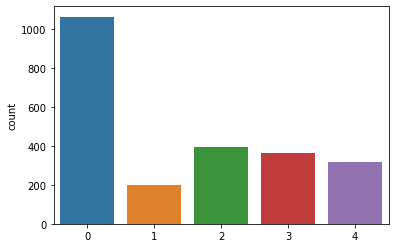

In [9]:
# label의 분포를 확인해 보자.
import seaborn as sns
sns.countplot(x=df_Ys.values.ravel())